# 过滤方法
* 基本过滤
* 相关过滤
* 统计和排名过滤

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('data/housing.csv')

In [4]:
data.shape

(1460, 63)

## 基本过滤
### Constant Features
去除常量特征，这些特征一般不会提供机器学习预测所需的信息。

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.drop(['SalePrice'], axis=1), 
                                                    data.SalePrice, test_size=0.3, 
                                                    random_state=0)
len(x_train.columns)
print(f'x_train:{len(x_train.columns)}, x_test:{len(x_test.columns)}')

x_train:62, x_test:62


In [6]:
numerical_x_train = x_train[x_train.select_dtypes([np.number]).columns]
len(numerical_x_train.columns)

35

In [7]:
# 移除所有那些方差不满足一些阈值的特征。默认情况下，它将会移除所有的零方差特征
from sklearn.feature_selection import VarianceThreshold
vs_constant = VarianceThreshold(threshold=0)

In [8]:
vs_constant.fit(numerical_x_train)
len(vs_constant.get_support())

35

In [9]:
len(x_train[x_train.select_dtypes([np.number]).columns].columns[vs_constant.get_support()])

34

In [10]:
constant_columns = [column for column in numerical_x_train.columns
                    if column not in numerical_x_train.columns[vs_constant.get_support()]]

In [11]:
constant_columns

['PoolArea']

In [12]:
constant_cat_columns = [column for column in x_train.columns 
                        if (x_train[column].dtype == "O" and len(x_train[column].unique())  == 1 )]

In [13]:
all_constant_columns = constant_cat_columns + constant_columns

In [14]:
x_train.drop(labels=constant_columns, axis=1, inplace=True)
x_test.drop(labels=constant_columns, axis=1, inplace=True)
print(f'x_train:{len(x_train.columns)}, x_test:{len(x_test.columns)}')

x_train:61, x_test:61


### Quasi Constant features
一个值占据大部分记录的准常量特征

In [15]:
threshold = 0.98

# create empty list
quasi_constant_feature = []

# loop over all the columns
for feature in x_train.columns:

    # calculate the ratio.
    predominant = (x_train[feature].value_counts() / np.float64(len(x_train))).sort_values(ascending=False).values[0]
    
    # append the column name if it is bigger than the threshold
    if predominant >= threshold:
        quasi_constant_feature.append(feature)
        
print(quasi_constant_feature)

['Street', 'Utilities', 'Condition2', 'LowQualFinSF', '3SsnPorch']


In [16]:
# drop the quasi constant columns
x_train.drop(labels=quasi_constant_feature, axis=1, inplace=True)
x_test.drop(labels=quasi_constant_feature, axis=1, inplace=True)
print(f'x_train:{len(x_train.columns)}, x_test:{len(x_test.columns)}')

x_train:56, x_test:56


### Duplicated Features

In [17]:
train_features_T = x_train.T
train_features_T.head()

,64,682,960,1384,1100,416,1034,853,472,1011,...,1094,599,277,1033,1383,763,835,1216,559,684
Id,65,683,961,1385,1101,417,1035,854,473,1012,...,1095,600,278,1034,1384,764,836,1217,560,685
MSSubClass,60,120,20,50,30,60,30,80,180,90,...,20,160,20,20,30,60,20,90,120,60
MSZoning,RL,RL,RL,RL,RL,RL,RL,RL,RM,RL,...,RL,RM,RL,RL,RL,RL,RL,RM,RL,RL
LotFrontage,70.049958,70.049958,50.0,60.0,60.0,74.0,50.0,70.049958,35.0,75.0,...,74.0,24.0,140.0,70.049958,70.049958,82.0,60.0,68.0,70.049958,58.0
LotArea,9375,2887,7207,9060,8400,7844,6305,12095,3675,9825,...,5868,1950,19138,8125,25339,9430,9600,8930,3196,16770


In [18]:
print(train_features_T.duplicated().sum())

0


In [19]:
duplicated_columns = train_features_T[train_features_T.duplicated()].index.values

In [20]:
x_train.drop(labels=duplicated_columns, axis=1, inplace=True)
x_test.drop(labels=duplicated_columns, axis=1, inplace=True)
print(f'x_train:{len(x_train.columns)}, x_test:{len(x_test.columns)}')

x_train:56, x_test:56


## 相关过滤方法
相关性被定义为衡量两个定量变量（如身高和体重）之间的线性关系。您还可以将相关性定义 为衡量一个变量对另一个变量的依赖程度。
如果两个变量之间高度相关，它们会提供关于目标的冗余信息。本质上，我们可以只用一个冗余变量对目标做出准确的预测。
删除相关变量有助于减少维度以及噪声。

### Pearson correlation coefficient（皮尔逊相关系数）
它用于总结两个数据变量之间线性关系的强度，可以在 1 和 -1 之间变化：
* 1 表示正相关：一个变量的值随着另一个变量的值增加而增加。
* -1 表示负相关： 一个变量的值随着另一个变量的值增加而减少。
* 0 表示两个变量之间没有线性相关性。

Pearson 相关系数的假设：

* 两个变量都应该是正态分布的。
* 两个变量之间是直线关系。
* 数据在回归线周围均匀分布。

### Spearman’s rank correlation coefficient（Spearman 等级相关系数）
有时，两个变量可以以非线性关系相关，这种关系在变量的分布中可能更强或更弱。它是一种非参数检验，用于衡量两个变量与单调函数之间的关联程度，即增加或减少的关系。
使用 Spearman 相关性测量的变量之间的强度在 +1 和 -1 之间变化，当每个变量都是另一个变量的完美单调函数时会发生这种情况。这很像 Pearson 相关性，但 Pearson 相关性评估线性关系，而 Spearman 相关性评估单调关系（无论是否线性）。

Spearman 系数适用于连续和离散的序数变量。
Spearman 等级相关性检验不对数据分布进行任何假设。

### Kendall’s rank correlation coefficient (Kendall等级相关系数)
Kendall 等级相关系数是一种非参数检验，用于衡量两个变量之间的序数关联的强度。Kendall 的相关性在 1 和 -1 之间变化。当观察值在两个变量之间具有相似等级时，它将取值 1（高），当观察值在两个变量之间具有不同等级时，取值 -1（低）。


In [21]:
correlated_features = set()
# method{‘pearson’, ‘kendall’, ‘spearman’}
correlation_matrix = x_train.corr()

<AxesSubplot:>

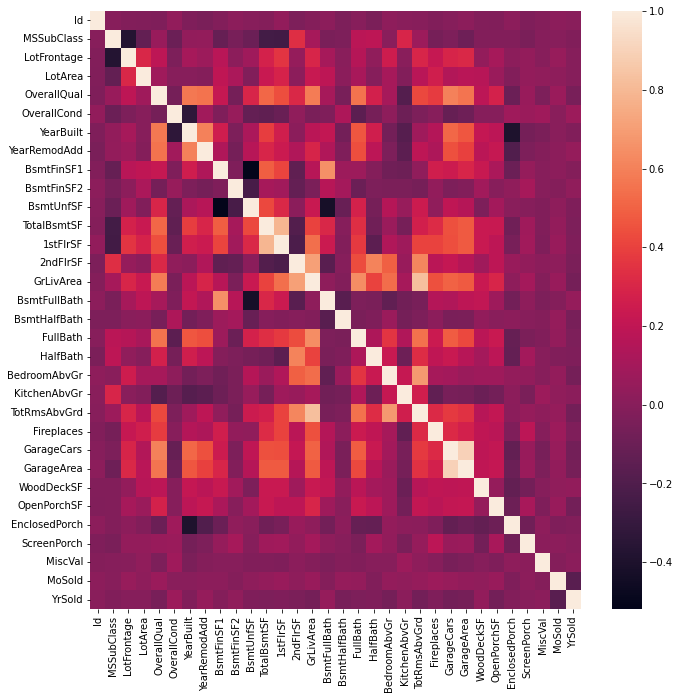

In [22]:
plt.figure(figsize=(11,11))
sns.heatmap(correlation_matrix)

In [23]:
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [24]:
correlated_features

{'GarageArea', 'TotRmsAbvGrd'}

In [25]:
x_train.drop(labels=correlated_features, axis=1, inplace=True)
x_test.drop(labels=correlated_features, axis=1, inplace=True)
print(f'x_train:{len(x_train.columns)}, x_test:{len(x_test.columns)}')

x_train:54, x_test:54


## Statistical Measures(统计和排名过滤方法)
本质上，这些方法根据某些标准或指标对特征进行排名，然后选择排名最高的特征。

In [26]:
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile

### Mutual Information(互信息，MI)
互信息量度两个变量的相互依赖关系。它衡量通过观察一个变量获得的关于另一个变量的信息量。在机器学习中，互信息衡量一个特征的存在/不存在有多少信息有助于对 Y 做出正确的预测。如果 X 和 Y 是独立的，则它们的 MI 为零。如果 X 是 Y 的确定性，则 MI 是 X 的熵，这是信息论中的一个概念，用于测量或量化变量内的信息量。

In [27]:
# select the number of features you want to retain.
select_k = 10

# get only the numerical features.
numerical_x_train = x_train[x_train.select_dtypes([np.number]).columns]


# create the SelectKBest with the mutual info strategy.
selection = SelectKBest(mutual_info_classif, k=select_k).fit(numerical_x_train, y_train)

features = [column for column in numerical_x_train.columns
                    if column in numerical_x_train.columns[selection.get_support()]]
# display the retained features.
# features = x_train.columns[selection.get_support()]
print(features)

['OverallQual', 'OverallCond', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars']


### Chi Squared Score（卡方分布）
是另一种统计方法，通常用于测试分类变量之间的关系。详情参考：https://zh.wikipedia.org/wiki/%E5%8D%A1%E6%96%B9%E5%88%86%E4%BD%88

适用于离散变量间的相关性检测

In [28]:
# change this to how much features you want to keep from the top ones.
select_k = 10

# apply the chi2 score on the data and target (target should be binary).  
selection = SelectKBest(chi2, k=select_k).fit(numerical_x_train, y_train)

# display the k selected features.
features = [column for column in numerical_x_train.columns
                    if column in numerical_x_train.columns[selection.get_support()]]
print(features)

['Id', 'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'ScreenPorch', 'MiscVal']


## Univariate RMSE 、 ROC-AUC
该方法使用机器学习模型来衡量两个变量的相关性。它适用于所有变量，并且不对它们的分布做任何假设。
流程：
* 使用单个变量和目标构建决策树。
* 根据模型 RMSE 或 ROC-AUC 对特征进行排名
* 选择排名得分较高的特征。
### Univariate RMSE
适用于回归问题。


In [29]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

numerical_x_train = x_train[x_train.select_dtypes([np.number]).columns]
numerical_x_test = x_test[x_test.select_dtypes([np.number]).columns]

def univariate_rmse():
    mse_values = []
    for feature in numerical_x_train.columns:
        clf = DecisionTreeRegressor()
        clf.fit(numerical_x_train[feature].to_frame(), y_train)
        y_scored = clf.predict(numerical_x_test[feature].to_frame())
        mse_values.append(mean_squared_error(y_test, y_scored))
    mse_values = pd.Series(mse_values)
    mse_values.index = numerical_x_train.columns
    print(mse_values.sort_values(ascending=False))
    print(len(mse_values[mse_values > threshold]),'out of the %s featues are kept'% len(numerical_x_train.columns))
    keep_col = mse_values[mse_values > threshold]
    return keep_col   

In [30]:
univariate_rmse()

Id               1.326803e+10
BsmtUnfSF        1.011789e+10
LotArea          8.379937e+09
BsmtFinSF1       7.696158e+09
WoodDeckSF       7.271460e+09
OpenPorchSF      6.886315e+09
MoSold           6.875928e+09
YrSold           6.832078e+09
LotFrontage      6.827291e+09
BsmtFinSF2       6.806977e+09
BsmtHalfBath     6.798179e+09
EnclosedPorch    6.797342e+09
MiscVal          6.791047e+09
ScreenPorch      6.707080e+09
KitchenAbvGr     6.665297e+09
BedroomAbvGr     6.642833e+09
1stFlrSF         6.496486e+09
BsmtFullBath     6.486271e+09
HalfBath         6.072529e+09
OverallCond      6.026309e+09
2ndFlrSF         5.816917e+09
TotalBsmtSF      5.669278e+09
Fireplaces       5.295673e+09
MSSubClass       5.258424e+09
GrLivArea        5.208607e+09
YearRemodAdd     5.138584e+09
YearBuilt        4.776575e+09
FullBath         4.740520e+09
GarageCars       3.524021e+09
OverallQual      2.097027e+09
dtype: float64
30 out of the 30 featues are kept


Id               1.326803e+10
MSSubClass       5.258424e+09
LotFrontage      6.827291e+09
LotArea          8.379937e+09
OverallQual      2.097027e+09
OverallCond      6.026309e+09
YearBuilt        4.776575e+09
YearRemodAdd     5.138584e+09
BsmtFinSF1       7.696158e+09
BsmtFinSF2       6.806977e+09
BsmtUnfSF        1.011789e+10
TotalBsmtSF      5.669278e+09
1stFlrSF         6.496486e+09
2ndFlrSF         5.816917e+09
GrLivArea        5.208607e+09
BsmtFullBath     6.486271e+09
BsmtHalfBath     6.798179e+09
FullBath         4.740520e+09
HalfBath         6.072529e+09
BedroomAbvGr     6.642833e+09
KitchenAbvGr     6.665297e+09
Fireplaces       5.295673e+09
GarageCars       3.524021e+09
WoodDeckSF       7.271460e+09
OpenPorchSF      6.886315e+09
EnclosedPorch    6.797342e+09
ScreenPorch      6.707080e+09
MiscVal          6.791047e+09
MoSold           6.875928e+09
YrSold           6.832078e+09
dtype: float64

### Univariate ROC-AUC
适用于分类问题

In [42]:
data = pd.read_csv('data/titanic.csv')
x_train, x_test, y_train, y_test = train_test_split(data.drop(['Survived'], axis=1), 
                                                    data.Survived, test_size=0.3, 
                                                    random_state=0)
numerical_x_train = x_train[x_train.select_dtypes([np.number]).columns].fillna(0)
numerical_x_test = x_test[x_test.select_dtypes([np.number]).columns].fillna(0)

def univariate_roc_auc():
    roc_values = []
    for feature in numerical_x_train.columns:
        clf = DecisionTreeClassifier()
        clf.fit(numerical_x_train[feature].to_frame(), y_train)
        y_scored = clf.predict_proba(numerical_x_test[feature].to_frame())
        roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    roc_values = pd.Series(roc_values)
    roc_values.index = numerical_x_train.columns
    print(roc_values.sort_values(ascending=False))
    print(len(roc_values[roc_values > threshold]),'out of the %s featues are kept'% len(numerical_x_train.columns))
    keep_col = roc_values[roc_values > threshold]
    return keep_col

In [43]:
# use it for a classification task.
univariate_roc_auc()

Fare           0.753304
Pclass         0.680476
Parch          0.610208
Age            0.585446
SibSp          0.577321
PassengerId    0.513571
dtype: float64
0 out of the 6 featues are kept


Series([], dtype: float64)